In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("c:/data/pima/data.csv")
df.columns

In [ ]:
X = df[['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'Diabetes_Pedigree_Function', 'age']]
y = df['outcome']

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'min_samples_split':range(2, 403, 10)},scoring=scoring,refit='AUC',return_train_score=True)
gs.fit(X,y)
results = gs.cv_results_
results

In [ ]:
results['mean_test_AUC']

In [ ]:
results['mean_test_Accuracy']

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(13,13))
plt.xlabel("min_sample_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0,402)
ax.set_ylim(0.73,1)

X_axis = np.array(results['param_min_samples_split'].data, dtype=float)
for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train','--'), ('test','-')):
        sample_score_mean = results['mean_%s_%s'%(sample,scorer)]
        ax.plot(X_axis, sample_score_mean, style, color=color, label="%s (%s)"%(scorer,sample))
    best_index = np.argmax(results['mean_test_%s'%scorer])
    best_score = results['mean_test_%s'%scorer][best_index]

    ax.plot([X_axis[best_index], ]*2, [0,best_score], linestyle='-.', color=color, marker='o', ms=20)
    ax.annotate("%0.2f"%best_score, (X_axis[best_index],best_score+0.005))

plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# 회귀트리

In [ ]:
import pandas as pd

df = pd.read_csv("c:/data/ram/ram_price.csv")
df.columns

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogy(df['date'], df['price']) # plot 함수와는 다르게 y축에 로그를 적용함
plt.xlabel('year')
plt.ylabel('price($/Mbyte)', size=15)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

# 회귀모델은 주관식이라 할 수 있음. DecisionTreeRegressor는 의사결정나무인데 답도 구할 수 있는 것

# 2000년 이전을 학습, 이후를 검증용
X_train0 = df[df['date']<2000]
X_test = df[df['date']>=2000]

# 기계학습모형에는 2차원 형태의 데이터가 들어가야 하기 때문에 여기서 2차원으로 만들어줌
X_train = X_train0['date'][:,None]
# y 값에 로그 적용
y_train = np.log(X_train0['price'])

tree = DecisionTreeRegressor().fit(X_train, y_train)
lr = LinearRegression().fit(X_train, y_train)

In [ ]:
x_all = np.array(df['date']).reshape(-1,1) # 2차원으로 변환
pred_tree = tree.predict(x_all)
price_tree = np.exp(pred_tree) # 로그의 역함수인 지수 함수 적용해서 값 구하기
pred_lr = lr.predict(x_all)
price_lr = np.exp(pred_lr)

In [ ]:
plt.figure(figsize=(15,10))
plt.semilogy(df['date'],price_tree,label='tree predict',lw='4',ls='--')
plt.semilogy(df['date'], price_lr, label='linear reg.predict', lw='4', ls=':')
plt.semilogy(X_train0['date'],X_train0['price'],label='train data', lw='4', alpha=0.4)
plt.semilogy(X_test['date'],X_test['price'],lw='4',label='test data')

plt.legend(loc=1, fontsize=20)
plt.show()

# 파란 점선인 의사결정나무 검증 모델을 보면 아무것도 못 맞추고 있음
# 빨간 선인 회귀 검증 모델을 보면 잘 맞추고 있음

In [ ]:
# 모형 결합, 앙상블 방법론

In [ ]:
import pandas as pd
df = pd.read_csv("c:/data/creditcard/creditcard.csv")
df.columns

In [ ]:
train_cols = df.columns[1:-1]
X = df[train_cols]
y = df["Class"]

from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X,y)
X_samp = pd.DataFrame(data=X_sample, columns=train_cols)
y_samp = pd.DataFrame(data=y_sample, columns=["Class"])
df2 = pd.concat([X_samp,y_samp],axis=1)
X = X_samp[train_cols]
y = y_samp["Class"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

model1 = LogisticRegression(random_state=1, max_iter=1000) # 회귀분석
model2 = DecisionTreeClassifier(random_state=1) # 의사결정나무
model3 = KNeighborsClassifier(n_neighbors=2) # k최근접이웃

ensemble = VotingClassifier(estimators=[('lr',model1),('tree',model2),('knn',model3)], voting='soft')

for model in (model1,model2,model3,ensemble):
    print(model)
    model.fit(X_train,y_train)
    print("학습용: ",model.score(X_train,y_train))
    print("검증용: ",model.score(X_test,y_test))
    print()

In [ ]:
# 모형결합(배깅)

In [ ]:
df = pd.read_csv("c:/data/customer/customer.csv")
df.columns

In [ ]:
train_cols = df.columns[0:16]
X = df[train_cols]
y = df["Churn"]

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X,y)
X_samp = pd.DataFrame(data=X_sample, columns=train_cols)
y_samp = pd.DataFrame(data=y_sample, columns=["Churn"])

df_samp = pd.concat([X_samp,y_samp],axis=1)

X = df_samp[train_cols]
y = df_samp["Churn"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

model1 = DecisionTreeClassifier(random_state=0)
model2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=0)

for model in (model1, model2):
    print(model)
    model.fit(X_train, y_train)
    print("학습용: ", model.score(X_train,y_train))
    print("검증용: ", model.score(X_test, y_test))
    print()

In [ ]:
# 모형결합(랜덤포레스트) 다시 하기!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# 부스팅

In [5]:
import pandas as pd

df = pd.read_csv("c:/data/pima/data.csv")

train_cols = df.columns[0:8]
X = df[train_cols]
y = df["outcome"]

In [6]:
from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)

X_samp = pd.DataFrame(data=X_sample,columns=train_cols)
y_samp = pd.DataFrame(data=y_sample,columns=['outcome'])
df_samp = pd.concat([X_samp,y_samp],axis=1)

df_samp["outcome"].value_counts()

0    268
1    268
Name: outcome, dtype: int64

In [7]:
X = df_samp[train_cols]
y = df_samp["outcome"]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

In [9]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier(n_estimators=100, random_state=0) # 모형의 개수 최대 100개
model_ada.fit(X_train, y_train)

print(model_ada.predict(X_test))
print(model_ada.score(X_train, y_train))
print(model_ada.score(X_test, y_test))

[0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0
 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0
 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1]
0.8761682242990654
0.6944444444444444


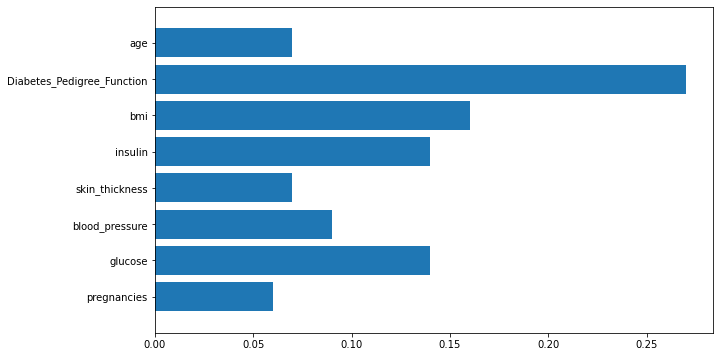

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot_tree(model):
    plt.figure(figsize=(10,6))
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_cols)
    plt.ylim(-1, n_features)

plot_tree(model_ada)

In [11]:
from sklearn.svm import SVC

svc = SVC(probability=True, kernel='linear')
model_svc = AdaBoostClassifier(algorithm='SAMME',n_estimators=50,base_estimator=svc)
model_svc.fit(X_train,y_train)

print(model_svc.predict(X_test))
print(model_svc.score(X_train, y_train))
print(model_svc.score(X_test, y_test))

[0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0
 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1]
0.7429906542056075
0.6851851851851852


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100,max_depth=3,random_state=0)
model_grad.fit(X_train,y_train)

print(model_grad.predict(X_test))
print(model_grad.score(X_train, y_train))
print(model_grad.score(X_test, y_test))

[0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1]
0.9228971962616822
0.75


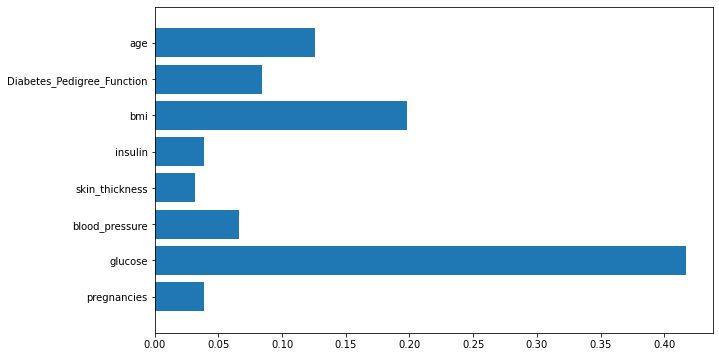

In [15]:
plot_tree(model_grad)

In [16]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimators=100,max_depth=3,random_state=0)
model_xgb.fit(X_train,y_train)

C:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
print(model_xgb.predict(X_test))
print(model_xgb.score(X_train, y_train))
print(model_xgb.score(X_test, y_test))

[0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1]
0.9976635514018691
0.75


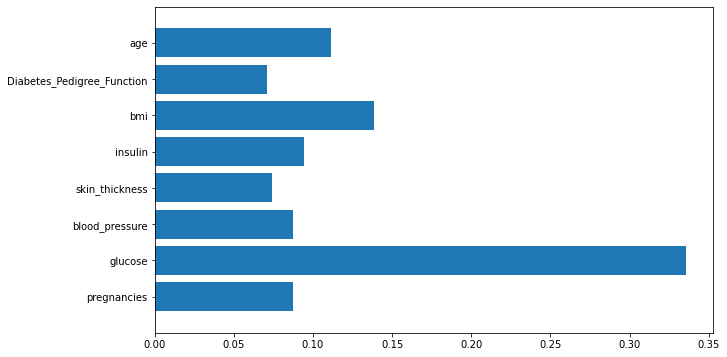

In [18]:
plot_tree(model_xgb)

In [19]:
import lightgbm

model_lgbm = lightgbm.LGBMClassifier(n_estimators=100,max_depth=3,random_state=0)
model_lgbm.fit(X_train,y_train)

print(model_lgbm.predict(X_test))
print(model_lgbm.score(X_train, y_train))
print(model_lgbm.score(X_test, y_test))

[0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0
 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1]
0.8995327102803738
0.7685185185185185


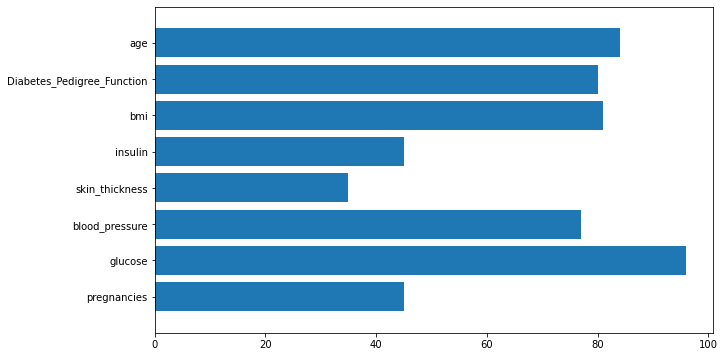

In [20]:
plot_tree(model_lgbm)